# Momentum

Momentum optimizer를 썼을 때 weight, velocity, cost의 변화를 시각적으로 살펴보자.

## 1. Prepare data

TV 광고에 따른 매출 변화 데이터

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('advertisement.csv')
data.head()

,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


In [3]:
X = data.loc[:, 'TV'].values
y = data.loc[:, 'Sales'].values

In [4]:
print('X shape: {}'.format(X.shape))
print('y shape: {}'.format(y.shape))

X shape: (200,)
y shape: (200,)


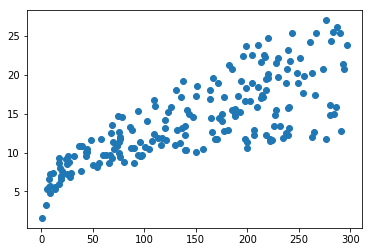

In [5]:
plt.scatter(X, y)
plt.show()
plt.close()

## 2. Loss shape : convex

- `advertisement.csv` 데이터에서 TV 광고 feature 하나만 사용
- 모델은 `f(x) = w*X + b` 형태로 사용

### 2.1 parameter가 독립이라면

- w와 b에 따른 loss의 변화를 그래프로 나타내면 아래와 같다. 둘 모두 convex 형태다.
- 물론 상관관계가 있기 때문에 아래 두 cost 그래프의 최적 w, b가 global optimum은 아니다.
- 단순히 각각이 convex 꼴인지만 시각적으로 보려고 그려봤다.

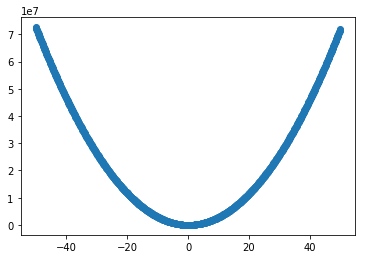

In [6]:
w_costs = []

for w in np.arange(-50, 50, 0.1):
    cost = np.sum(np.square(w * X - y)) / len(X)
    w_costs.append(cost)

plt.scatter(np.arange(-50, 50, 0.1), w_costs)
plt.show()
plt.close()

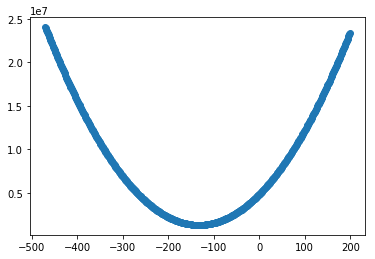

In [7]:
b_costs = []
start = -470
end = 200
for b in np.arange(start, end, 1):
    cost = np.sum(np.square(X + b - y))
    b_costs.append(cost)

plt.scatter(np.arange(start, end, 1), b_costs)
plt.show()
plt.close()

### 2.2 Optimum value

- sklearn의 linear regression 모델을 활용해서 최적의 w, b를 구해보면 다음과 같다.
- 위 독립임을 가정하고 구했을 때의 최적값과 실제로 다르다 => 상관성 존재

In [8]:
from sklearn.linear_model import LinearRegression

In [9]:
X_input = X.reshape(-1, 1)
X_input.shape

(200, 1)

In [10]:
model = LinearRegression()
model.fit(X_input, y)

/Users/qbinson/.virtualenvs/fira/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [11]:
print('coef: {}'.format(model.coef_))
print('intercept: {}'.format(model.intercept_))

coef: [ 0.04753664]
intercept: 7.032593549127695


## 3. Training

### 3.1 Momentum optimizer

$$
m_t = \beta m_{t-1} + \eta d \\
\theta_t = \theta_{t-1} - m_t
$$

- $m_t$ : t 시점의 velocity
- $\beta$ : friction(마찰)
- $\eta$ : learning rate(eta)
- $\theta_t$ : t 시점의 weight vector

In [12]:
# Global variables (X, y also)
BETA = 0.9 # friction
ETA = 0.00000001 # learning rate

VELOCITIES= [{'w':0, 'b':0}] # initialized to 0
PARAMS = [{'w':12.5, 'b':0.8}] # random initialization
DERIVATIVES = []
COSTS = []

# Equations
def get_next_vw(m_past, dw):
    m = BETA * m_past + ETA * dw
    return m

def get_next_vb(m_past, db):
    m = BETA * m_past + ETA * db
    return m

def get_next_w(w_past, m):
    w = w_past - m
    return w

def get_next_b(b_past, m):
    b = b_past - m
    return b

### 3.2 Training

- propagate할 때 cost와 derivatives를 구한다
- backpropagate할 때 momentum으로 weight 업데이트

In [13]:
def propagate(w, b):
    cost = np.sum(np.square(w * X - y)) / len(X)
    dw = np.dot(w*X + b - y, X) / len(X)
    db = np.sum(w*X + b - y) / len(X)
    return cost, dw, db

def back_propagate(w, b, dw, db):
    next_vw = get_next_vw(w, dw)
    next_w = get_next_w(w, next_vw)
    
    next_vb = get_next_vb(b, db)
    next_b = get_next_b(b, next_vb)
    
    return next_vw, next_vb, next_w, next_b

In [14]:
min_cost = np.inf
max_bad_iteration = 5
best_idx = 0

for i in range(1000):
    # Forward propagate
    cost, dw, db = propagate(PARAMS[i]['w'], PARAMS[i]['b'])
    if cost < min_cost:
        min_cost = cost
        max_bad_iteration = 5
        best_idx = i
    else:
        max_bad_iteration -= 1
        if max_bad_iteration == 0:
            break
    COSTS.append(cost)
    DERIVATIVES.append({'w':dw, 'b':db})
    
    # Backword propagate
    next_vw, next_vb, next_w, next_b = back_propagate(PARAMS[i]['w'], PARAMS[i]['b'], dw, db)
    VELOCITIES.append({'w':next_vw, 'b':next_vb})
    PARAMS.append({'w':next_w, 'b':next_b})

In [15]:
print("len: {}".format(len(PARAMS)))
print(PARAMS[-2])
print(COSTS[-1])

len: 8
{'w': 3.9059484774035103e-05, 'b': 9.5466631151392943e-07}
223.527985142


In [16]:
np.sum(np.square((0.04753664 * X + 7.032593549127695) - y))

2102.5305831313522

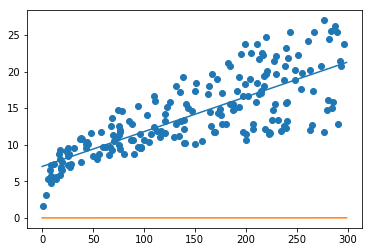

In [17]:
plt.scatter(X, y)
plt.plot(range(300), np.array(range(300)) * 0.04753664 + 7.032593549127695)
plt.plot(range(300), np.array(range(300)) * 2.8000054168609359e-05 + 2.3563418756183097e-07)
plt.show()
plt.close()

In [18]:
np.array(range(10))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

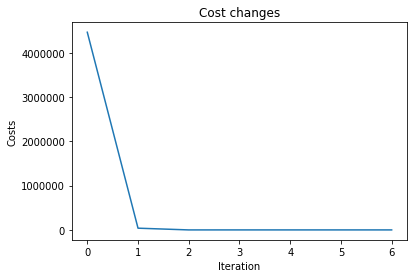

In [19]:
iteration = len(COSTS)
plt.plot(range(iteration), COSTS[:iteration])
plt.title('Cost changes')
plt.xlabel('Iteration')
plt.ylabel('Costs')
plt.show()
plt.close()

In [20]:
map(PARAMS)
plt.plot(range(101), WEIGHTS[:101])
plt.title('Weight changes')
plt.xlabel('Iteration')
plt.ylabel('Weight value')
plt.show()
plt.close()

NameError: name 'WEIGHTS' is not defined

In [ ]:
plt.plot(range(101), BIASES[:101])
plt.title('Weight changes')
plt.xlabel('Iteration')
plt.ylabel('Weight value')
plt.show()
plt.close()

In [ ]:
plt.plot(range(101), VELOCITIES_W[:101])
plt.title('Velocity changes')
plt.xlabel('Iteration')
plt.ylabel('Velocity')
plt.show()
plt.close()

In [ ]:
plt.plot(range(101), VELOCITIES_B[:101])
plt.title('Velocity changes')
plt.xlabel('Iteration')
plt.ylabel('Velocity')
plt.show()
plt.close()

In [ ]:
plt.plot(range(101), DERIVATIVES_W[:101])
plt.title('Derivative changes')
plt.xlabel('Iteration')
plt.ylabel('Derivative')
plt.show()
plt.close()

In [ ]:
plt.plot(range(101), DERIVATIVES_B[:101])
plt.title('Derivative changes')
plt.xlabel('Iteration')
plt.ylabel('Derivative')
plt.show()
plt.close()

## 4. Simple example

### 4.1 Simple loss

In [ ]:
theta = np.arange(-10, 10, 0.01)

In [ ]:
def get_loss(x):
    return max(-x, x)

In [ ]:
loss = []
for t in theta:
    loss.append(get_loss(t))

In [ ]:
plt.scatter(theta, loss)
plt.show()
plt.close()

### 4.2 Velocity and theta

In [ ]:
beta = 0.9 # friction
eta = 0.01 # learning rate
d = 1 # Assume theta is initialized to any positive value
m = 0
t = 0
thetas = [8.5]
velocities = [0]

In [ ]:
def get_next_veloicty(m):
    return beta * m + eta * d

In [ ]:
def get_next_theta(theta, m):
    return theta - m

In [ ]:
for i in range(50):
    next_v = get_next_veloicty(velocities[i])
    velocities.append(next_v)
    next_t = get_next_theta(thetas[i], next_v)
    thetas.append(next_t)

현재 기울기를 1로 고정해놨기 때문에 계속 theta 값은 줄어든다. 그래프에서 보면 점점 빠르게 줄어드는 것을 볼 수 있다.

In [ ]:
plt.scatter(range(51), thetas)
plt.show()
plt.close()

m 값, 즉 velocity는 계속 증가하긴 하는데 결국 terminal velocity 값이 존재한다.

In [ ]:
plt.scatter(range(51), velocities)
plt.show()
plt.close()